In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

Found existing installation: sklearn 0.0.post1
Uninstalling sklearn-0.0.post1:
  Successfully uninstalled sklearn-0.0.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn
sklearn.__version__

'0.23.2'

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
!pip install pycaret[full] --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 4.6 MB/s 
  Created wheel for pyod: filename=pyod-1.0.6-py3-none-any.whl size=175098 sha256=e86e391050dcde59ba6b1180bfc66b6c5d902bbeed5252c8c2703bb9e5efc0fe
  Stored in directory: /root/.cache/pip/wheels/98/93/e6/6d40410d9635ecde42d06041a1ba7f2ee7396e036fcf702e73
Successfully built pyod

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.3.10 requires Boruta, which is not installed.
pycaret 2.3.10 requires kmodes>=0.10.1, which is not installed.
pycaret 2.3.10 requires mlflow, which is not installed.
pycaret 2.3.10 requires pyLDAvis, which is not installed.
pycaret 2.3.10 requires umap-learn, which is not installed.
pycaret 2.3.10 requires imbalanced-learn==0.7.0, but you have imbalanced-learn 0.8.1 which is in

In [ ]:
import sys
import pandas as pd
import numpy as np

import optuna  # 파라미터 튜닝
import shap
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor

from pycaret.regression import * 
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, mean_absolute_error

from scipy import stats
from scipy.stats import norm, skew

from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ML/project

/content/drive/MyDrive/ML/project


# Experiment 3 <br>

y_label의 값인 0과 1의 비율을 1:1로 만든 후 모델링 <br>

In [ ]:
train = train[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR','Y_LABEL','Label','Score_1']]
real_test = real_test[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]

In [ ]:
# Label 기준으로 split
train, test = train_test_split(train, stratify=train.Label, test_size=0.2, random_state=42)

In [ ]:
# YEAR 칼럼 LabelEncoding
le = LabelEncoder()
train.YEAR = le.fit_transform(train.YEAR)
test.YEAR = le.transform(test.YEAR)
real_test.YEAR = le.transform(real_test.YEAR)

In [ ]:
numeric_feats = []

for col in train.columns:
    if col not in ['YEAR','Score_1','Label','Y_LABEL']:
        numeric_feats.append(col)

# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
CR,53.601677
ANONYMOUS_1,32.396129
FE,22.304026
CU,19.550846
NI,17.997284
V40,14.774742
PQINDEX,10.164341
ANONYMOUS_2,8.101399
MO,2.853648
ZN,0.228219


In [ ]:
skewness = skewness[abs(skewness.Skew) > 0.75]

skewed_features = skewness.index

# log 변환
for col in skewed_features:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])
    real_test[col] = np.log1p(real_test[col])

In [ ]:
print(train.Y_LABEL.value_counts())
print(test.Y_LABEL.value_counts())
print(train.Label.value_counts())
print(test.Label.value_counts())

0    10325
1      951
Name: Y_LABEL, dtype: int64
0    2567
1     252
Name: Y_LABEL, dtype: int64
0    10526
1      750
Name: Label, dtype: int64
0    2631
1     188
Name: Label, dtype: int64


## Labeling, Metric

In [ ]:
def labeling(prob, threshold):
    return 1 if prob > threshold else 0

def competition_metric(pred, org):
    return round(f1_score(pred, org),4), round(f1_score(pred, org, average='macro'),4)

## DownSample Dataset

암 vs 스펨 -> 스펨메일과 같은 경우

스펨이 아닌 것을 스펨이라고 하는 것보다 스펨인 것을 스펨이 아니라고 판정하는게 더 치명적

In [ ]:
train1 = train[train.Score_1 > 0.4].reset_index(drop=True)
train0 = train[train.Score_1 <= 0.4].reset_index(drop=True)

In [ ]:
len(train0)

10458

In [ ]:
len(train1)

818

In [ ]:
# test 데이터 설정
X_test = test[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_test = test[['Y_LABEL', 'Score_1']]


- 비율 1:1
- Row 1500

In [ ]:
len(train1)*7

5726

In [ ]:
train00 = train0.sample(n=len(train1)*7, random_state=42).reset_index(drop=True) 

for i in range(818,5727,818):
  globals()['train0{}'.format(round(i/818))] = pd.concat([train00.iloc[i-818:i,:], train1], axis=0).sample(frac=1).reset_index(drop=True)

In [ ]:
X_train1 = train01[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train1 = train01[['Label','Score_1']]
X_train2 = train02[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train2 = train02[['Label','Score_1']]
X_train3 = train03[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train3 = train03[['Label','Score_1']]
X_train4 = train04[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train4 = train04[['Label','Score_1']]
X_train5 = train05[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train5 = train05[['Label','Score_1']]
X_train6 = train06[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train6 = train06[['Label','Score_1']]
X_train7 = train07[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train7 = train07[['Label','Score_1']]

### Decision Tree

In [ ]:
def objectiveDT(trial, X, y):
    
    param = {
    'criterion': trial.suggest_categorical('criterion',['mae']),
    'splitter': trial.suggest_categorical('splitter',['best','random']),
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_1'], y.loc[test_idx,'Score_1']

        #학습모델 생성
        model = DecisionTreeRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-10 10:54:12,842] A new study created in memory with name: no-name-975973f5-befd-44d4-a545-c833dc79722f
[I 2022-12-10 10:54:13,092] Trial 0 finished with value: 0.36953520269262324 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 753}. Best is trial 0 with value: 0.36953520269262324.
[I 2022-12-10 10:54:13,376] Trial 1 finished with value: 0.3877121771276199 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 12, 'max_leaf_nodes': 819}. Best is trial 0 with value: 0.36953520269262324.
[I 2022-12-10 10:54:13,552] Trial 2 finished with value: 0.36598966668531363 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 5, 'max_leaf_nodes': 658}. Best is trial 2 with value: 0.36598966668531363.
[I 2022-12-10 10:54:13,791] Trial 3 finished with value: 0.3756408334265682 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 9, 'max_leaf_nodes': 168}. Best is trial 2 with value: 0.365989

study.best_params: 0.34683575399045274
Number of finished trials: 100
Best trial: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 342}
study.best_params: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 342}


In [ ]:
param_dt = studyDT.best_params

clf_dt = DecisionTreeRegressor(**param_dt, random_state=42)

In [ ]:
clf_dt.fit(X_train1, y_train1.Score_1)

pred_test_dt = clf_dt.predict(X_test)

y_test['pred_dt'] = [labeling(pred, 0.4) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.2382
F1 Score : 0.2341
Macro F1 Score : 0.4852 

[[1544   83]
 [1023  169]]


In [ ]:
optuna.visualization.plot_param_importances(studyDT)

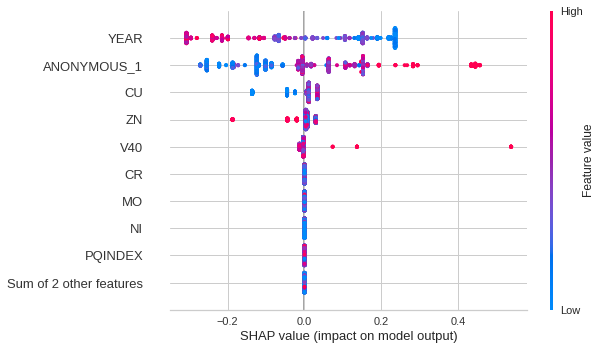

In [ ]:
explainer_dt = shap.Explainer(clf_dt)
shap_values_dt = explainer_dt(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [ ]:
fi_dt = pd.DataFrame(clf_dt.feature_importances_, index=X_train1.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

,feature_importance_dt
ANONYMOUS_1,0.532980
YEAR,0.367418
ZN,0.037767
V40,0.033320
CU,0.028516
FE,0.000000
ANONYMOUS_2,0.000000
PQINDEX,0.000000
NI,0.000000
MO,0.000000


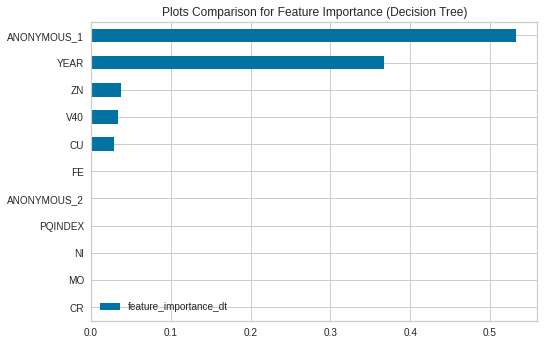

In [ ]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [ ]:
def objectiveSVR(trial, X, y):
    
    param = {
        'C': trial.suggest_loguniform('C', 0.3, 10.0),
        'degree': trial.suggest_int('degree', 2, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 0.01),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.5),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_1'], y.loc[test_idx,'Score_1']

        #학습모델 생성
        model = SVR(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-10 10:59:31,969] A new study created in memory with name: no-name-de23d5ea-2a2c-44f6-a8b0-0bf94c902612
[I 2022-12-10 10:59:32,880] Trial 0 finished with value: 0.38402403244513794 and parameters: {'C': 0.8665580394349462, 'degree': 2, 'gamma': 0.0011671720380504748, 'epsilon': 0.11828901660855647}. Best is trial 0 with value: 0.38402403244513794.
[I 2022-12-10 10:59:33,562] Trial 1 finished with value: 0.3967407299444084 and parameters: {'C': 0.3875233525858074, 'degree': 3, 'gamma': 0.0010485552560414052, 'epsilon': 0.4192276652059847}. Best is trial 0 with value: 0.38402403244513794.
[I 2022-12-10 10:59:34,308] Trial 2 finished with value: 0.3979403566630276 and parameters: {'C': 1.9343579526788284, 'degree': 2, 'gamma': 0.0038728191519844407, 'epsilon': 0.44330856056157314}. Best is trial 0 with value: 0.38402403244513794.
[I 2022-12-10 10:59:35,106] Trial 3 finished with value: 0.38874828649783283 and parameters: {'C': 2.6945020366843146, 'degree': 3, 'gamma': 0.00106480

study.best_params: 0.3789830806498065
Number of finished trials: 100
Best trial: {'C': 3.2285328400450157, 'degree': 6, 'gamma': 0.0010630819196863546, 'epsilon': 0.08266680128408369}
study.best_params: {'C': 3.2285328400450157, 'degree': 6, 'gamma': 0.0010630819196863546, 'epsilon': 0.08266680128408369}


In [ ]:
param_svr = studySVR.best_params

clf_svr = SVR(**param_svr)

In [ ]:
clf_svr.fit(X_train2, y_train2.Score_1)

pred_test_svr = clf_svr.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.4) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.3279
F1 Score : 0.1992
Macro F1 Score : 0.4814 

[[1662  124]
 [ 905  128]]


In [ ]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [ ]:
def objectiveRF(trial, X, y):

    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),  # max_depth 제한
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),  # n_estimators 제한
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_1'], y.loc[test_idx,'Score_1']

        #학습모델 생성
        model = RandomForestRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-10 11:54:46,828] A new study created in memory with name: no-name-2902551a-6cf3-4be4-a95a-0c1178eaa363
[I 2022-12-10 11:55:02,736] Trial 0 finished with value: 0.37210653055252274 and parameters: {'max_depth': 4, 'max_leaf_nodes': 243, 'n_estimators': 439}. Best is trial 0 with value: 0.37210653055252274.
[I 2022-12-10 11:55:21,846] Trial 1 finished with value: 0.3643655840820449 and parameters: {'max_depth': 8, 'max_leaf_nodes': 497, 'n_estimators': 500}. Best is trial 1 with value: 0.3643655840820449.
[I 2022-12-10 11:55:32,739] Trial 2 finished with value: 0.3654185232599278 and parameters: {'max_depth': 7, 'max_leaf_nodes': 697, 'n_estimators': 429}. Best is trial 1 with value: 0.3643655840820449.
[I 2022-12-10 11:55:45,726] Trial 3 finished with value: 0.3627513863101141 and parameters: {'max_depth': 11, 'max_leaf_nodes': 177, 'n_estimators': 389}. Best is trial 3 with value: 0.3627513863101141.
[I 2022-12-10 11:55:52,938] Trial 4 finished with value: 0.3760559836641718

study.best_params: 0.36181776366870166
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 130, 'n_estimators': 326}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 130, 'n_estimators': 326}


In [ ]:
param_rf = studyRF.best_params

clf_rf = RandomForestRegressor(**param_rf, random_state=42)

In [ ]:
clf_rf.fit(X_train3, y_train3.Score_1)

pred_test_rf = clf_rf.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.4) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.3529
F1 Score : 0.2195
Macro F1 Score : 0.4533 

[[1383   75]
 [1184  177]]


In [ ]:
y_test['pred_rf'] = [labeling(pred, 0.5) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.3529
F1 Score : 0.2293
Macro F1 Score : 0.5399 

[[2008  147]
 [ 559  105]]


In [ ]:
optuna.visualization.plot_param_importances(studyRF)

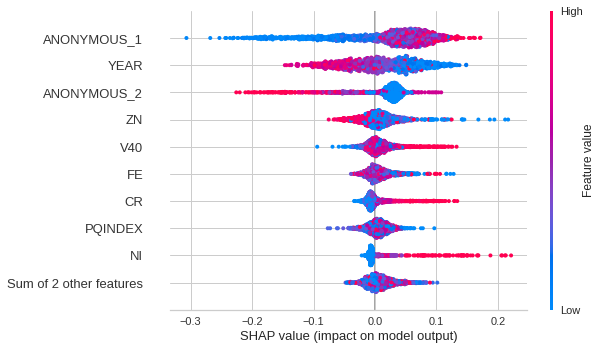

In [ ]:
explainer_rf = shap.Explainer(clf_rf)
shap_values_rf = explainer_rf(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [ ]:
fi_rf = pd.DataFrame(clf_rf.feature_importances_, index=X_train3.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

,feature_importance_rf
ANONYMOUS_1,0.187864
V40,0.116690
ZN,0.113004
FE,0.102090
PQINDEX,0.101155
YEAR,0.097325
ANONYMOUS_2,0.078847
CU,0.070943
MO,0.049888
CR,0.048762


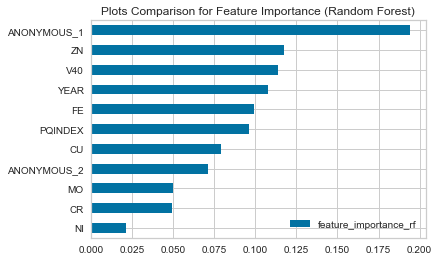

In [ ]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [ ]:
def objectiveXGB(trial, X, y):

    param = {
    'verbosity':1,
    'objective': trial.suggest_categorical('objective',['reg:squarederror']),
    'max_depth':trial.suggest_int('max_depth',3,13),  # 데이터 수가 적어 3~13으로 제한
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_1'], y.loc[test_idx,'Score_1']

        #학습모델 생성
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-10 12:12:01,100] A new study created in memory with name: no-name-228672ab-1e1b-4655-b5e4-5ad0ec4d4c07
[I 2022-12-10 12:12:01,689] Trial 0 finished with value: 0.4055759355187588 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 1.3058633161635208e-08, 'n_estimators': 204, 'subsample': 0.7914194214480772, 'min_child_weight': 75, 'alpha': 0.8623368846168337}. Best is trial 0 with value: 0.4055759355187588.
[I 2022-12-10 12:12:06,698] Trial 1 finished with value: 0.40169569902356167 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.0004113663432549334, 'n_estimators': 313, 'subsample': 0.7243310465940057, 'min_child_weight': 95, 'alpha': 0.9263987844748088}. Best is trial 1 with value: 0.40169569902356167.
[I 2022-12-10 12:12:07,033] Trial 2 finished with value: 0.40557592113897717 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 1.8057178531979483e-07, 'n_estimators': 492, 

study.best_params: 0.3609847192323131
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.009965752312650828, 'n_estimators': 367, 'subsample': 0.9389734941490345, 'min_child_weight': 34, 'alpha': 1.6022532141016184}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.009965752312650828, 'n_estimators': 367, 'subsample': 0.9389734941490345, 'min_child_weight': 34, 'alpha': 1.6022532141016184}


In [ ]:
param_xgb = studyXGB.best_params

clf_xgb = xgb.XGBRegressor(**param_xgb, random_state=42)

In [ ]:
clf_xgb.fit(X_train4, y_train4.Score_1)

pred_test_xgb = clf_xgb.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, 0.4) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.349
F1 Score : 0.2169
Macro F1 Score : 0.4625 

[[1454   86]
 [1113  166]]


In [ ]:
y_test['pred_xgb'] = [labeling(pred, 0.5) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.349
F1 Score : 0.2264
Macro F1 Score : 0.5396 

[[2020  150]
 [ 547  102]]


In [ ]:
optuna.visualization.plot_param_importances(studyXGB)

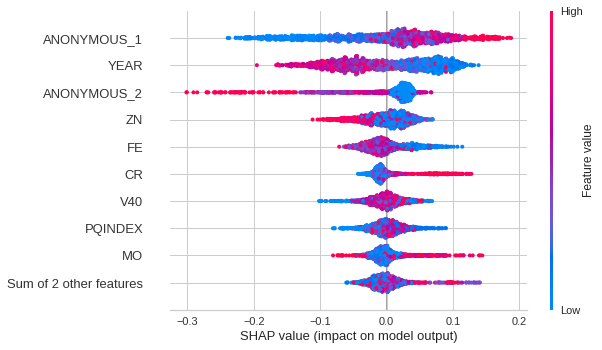

In [ ]:
explainer_xgb = shap.Explainer(clf_xgb)
shap_values_xgb = explainer_xgb(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [ ]:
fi_xgb = pd.DataFrame(clf_xgb.feature_importances_, index=X_train4.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

,feature_importance_xgb
ANONYMOUS_2,0.137844
NI,0.123120
YEAR,0.109308
CR,0.103859
ANONYMOUS_1,0.099698
MO,0.076846
FE,0.074518
CU,0.070371
PQINDEX,0.068655
ZN,0.068117


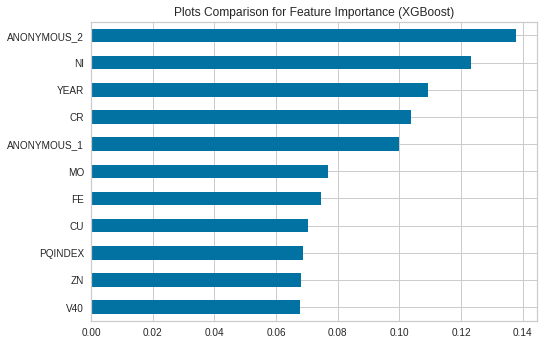

In [ ]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
plt.legend([])  # 범례 없애기
plt.show()

### LGBM

In [ ]:
def objectiveLGBM(trial, X, y):

    param = {
        'metric': 'mae', 
        'random_state': 42,
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
#         'max_depth':trial.suggest_int('max_depth',3,30),
        'num_leaves' : trial.suggest_categorical('num_leaves', [8,16,32,64,128,256,512,1024]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_1'], y.loc[test_idx,'Score_1']

        #학습모델 생성
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-10 12:24:35,330] A new study created in memory with name: no-name-71bc0f5d-87f2-43fd-8dc2-5fee8d903dfc
[I 2022-12-10 12:24:35,824] Trial 0 finished with value: 0.403733046858469 and parameters: {'n_estimators': 409, 'reg_alpha': 0.03282975987259092, 'reg_lambda': 0.19386132411061544, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 5.887831028615282e-07, 'num_leaves': 32, 'min_child_samples': 253, 'min_data_per_groups': 84}. Best is trial 0 with value: 0.403733046858469.
[I 2022-12-10 12:24:36,230] Trial 1 finished with value: 0.4035034372995711 and parameters: {'n_estimators': 138, 'reg_alpha': 0.019040973009549492, 'reg_lambda': 0.6139847032274216, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 5.597103648817927e-05, 'num_leaves': 256, 'min_child_samples': 99, 'min_data_per_groups': 43}. Best is trial 1 with value: 0.4035034372995711.
[I 2022-12-10 12:24:36,778] Trial 2 finished with value: 0.4037195977217011 and parameters: {'n_estimators': 484, 'r

study.best_params: 0.36899321257003237
Number of finished trials: 100
Best trial: {'n_estimators': 324, 'reg_alpha': 0.051617660436503454, 'reg_lambda': 0.013998971550598595, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.007246255922935249, 'num_leaves': 128, 'min_child_samples': 21, 'min_data_per_groups': 86}
study.best_params: {'n_estimators': 324, 'reg_alpha': 0.051617660436503454, 'reg_lambda': 0.013998971550598595, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.007246255922935249, 'num_leaves': 128, 'min_child_samples': 21, 'min_data_per_groups': 86}


In [ ]:
param_lgbm = studyLGBM.best_params

clf_lgbm = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [ ]:
clf_lgbm.fit(X_train5, y_train5.Score_1)

pred_test_lgbm = clf_lgbm.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, 0.4) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

MAE : 0.3519
F1 Score : 0.2127
Macro F1 Score : 0.4582 

[[1441   88]
 [1126  164]]


In [ ]:
y_test['pred_lgbm'] = [labeling(pred, 0.5) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

MAE : 0.3519
F1 Score : 0.2163
Macro F1 Score : 0.5295 

[[1978  150]
 [ 589  102]]


In [ ]:
optuna.visualization.plot_param_importances(studyLGBM)

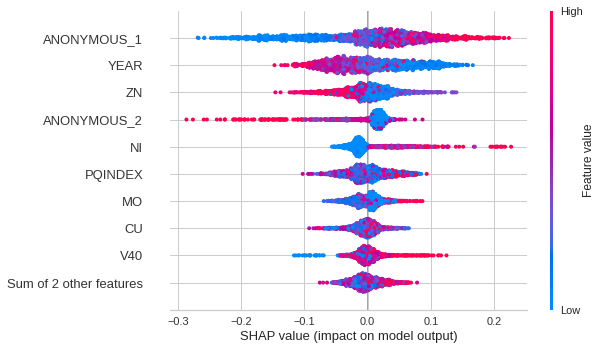

In [ ]:
explainer_lgbm = shap.Explainer(clf_lgbm)
shap_values_lgbm = explainer_lgbm(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [ ]:
fi_lgbm = pd.DataFrame(clf_lgbm.feature_importances_, index=X_train5.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

,feature_importance_lgbm
ANONYMOUS_1,3311
ZN,2850
V40,2160
PQINDEX,2106
FE,2006
CU,1666
YEAR,1596
MO,1374
ANONYMOUS_2,876
CR,752


In [ ]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

,feature_importance_lgbm
ANONYMOUS_1,0.174071
ZN,0.149834
V40,0.113559
PQINDEX,0.110720
FE,0.105462
CU,0.087587
YEAR,0.083907
MO,0.072236
ANONYMOUS_2,0.046054
CR,0.039535


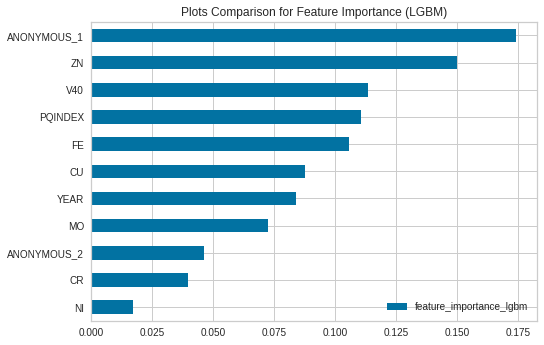

In [ ]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [ ]:
def objectiveCB(trial, X, y):
    
    param = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'max_depth':trial.suggest_int('max_depth',3,13),
        'random_state': 42,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_1'], y.loc[test_idx,'Score_1']

        #학습모델 생성
        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train6, y_train6), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-10 12:31:39,760] A new study created in memory with name: no-name-150bd4c1-5ac1-4a9b-b73c-28b54a4c48f0
[I 2022-12-10 12:31:43,113] Trial 0 finished with value: 0.37617128395679095 and parameters: {'l2_leaf_reg': 2.4787695670682988, 'max_bin': 356, 'learning_rate': 0.011953552148971912, 'n_estimators': 280, 'max_depth': 3, 'min_data_in_leaf': 244}. Best is trial 0 with value: 0.37617128395679095.
[I 2022-12-10 12:35:48,498] Trial 1 finished with value: 0.37949787959500697 and parameters: {'l2_leaf_reg': 0.003191788319882422, 'max_bin': 301, 'learning_rate': 0.007404814056166239, 'n_estimators': 219, 'max_depth': 13, 'min_data_in_leaf': 239}. Best is trial 0 with value: 0.37617128395679095.
[I 2022-12-10 12:35:53,641] Trial 2 finished with value: 0.36862617056906205 and parameters: {'l2_leaf_reg': 0.445848341593142, 'max_bin': 265, 'learning_rate': 0.015253435607300388, 'n_estimators': 434, 'max_depth': 4, 'min_data_in_leaf': 189}. Best is trial 2 with value: 0.368626170569062

study.best_params: 0.3655732959823189
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.0010487064890156348, 'max_bin': 237, 'learning_rate': 0.016795647274357662, 'n_estimators': 477, 'max_depth': 5, 'min_data_in_leaf': 126}
study.best_params: {'l2_leaf_reg': 0.0010487064890156348, 'max_bin': 237, 'learning_rate': 0.016795647274357662, 'n_estimators': 477, 'max_depth': 5, 'min_data_in_leaf': 126}


In [ ]:
param_cat = studyCB.best_params

clf_cat = CatBoostRegressor(**param_cat, random_state=42)

In [ ]:
clf_cat.fit(X_train6, y_train6.Score_1)

pred_test_cat = clf_cat.predict(X_test)

y_test['pred_cat'] = [labeling(pred, 0.4) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.4273214	total: 2.07ms	remaining: 984ms
1:	learn: 0.4266917	total: 4.51ms	remaining: 1.07s
2:	learn: 0.4260817	total: 6.49ms	remaining: 1.02s
3:	learn: 0.4256109	total: 8.48ms	remaining: 1s
4:	learn: 0.4250222	total: 10.3ms	remaining: 970ms
5:	learn: 0.4243586	total: 12.2ms	remaining: 961ms
6:	learn: 0.4237972	total: 14.1ms	remaining: 949ms
7:	learn: 0.4231907	total: 15.9ms	remaining: 932ms
8:	learn: 0.4228606	total: 17.9ms	remaining: 929ms
9:	learn: 0.4223096	total: 20.2ms	remaining: 942ms
10:	learn: 0.4218183	total: 22.2ms	remaining: 941ms
11:	learn: 0.4212300	total: 24.5ms	remaining: 949ms
12:	learn: 0.4207746	total: 26.5ms	remaining: 948ms
13:	learn: 0.4203040	total: 28.2ms	remaining: 934ms
14:	learn: 0.4198369	total: 30.2ms	remaining: 930ms
15:	learn: 0.4193972	total: 32.3ms	remaining: 930ms
16:	learn: 0.4189517	total: 34.4ms	remaining: 931ms
17:	learn: 0.4185293	total: 36.4ms	remaining: 929ms
18:	learn: 0.4180756	total: 38.5ms	remaining: 928ms
19:	learn: 0.4177162	tota

In [ ]:
y_test['pred_cat'] = [labeling(pred, 0.5) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

MAE : 0.3483
F1 Score : 0.2451
Macro F1 Score : 0.5638 

[[2153  159]
 [ 414   93]]


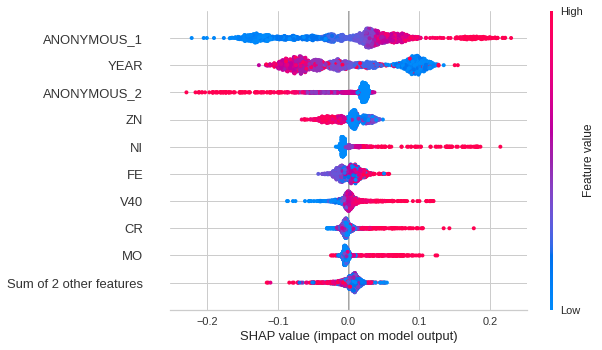

In [ ]:
explainer_cat = shap.Explainer(clf_cat)
shap_values_cat = explainer_cat(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [ ]:
fi_cat = pd.DataFrame(clf_cat.feature_importances_, index=X_train6.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

,feature_importance_cat
YEAR,20.604267
ANONYMOUS_1,19.230737
ANONYMOUS_2,11.695563
V40,7.698653
ZN,7.519735
FE,6.750921
CR,6.567716
PQINDEX,6.031846
MO,4.836042
CU,4.668441


In [ ]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

,feature_importance_cat
YEAR,0.206043
ANONYMOUS_1,0.192307
ANONYMOUS_2,0.116956
V40,0.076987
ZN,0.075197
FE,0.067509
CR,0.065677
PQINDEX,0.060318
MO,0.048360
CU,0.046684


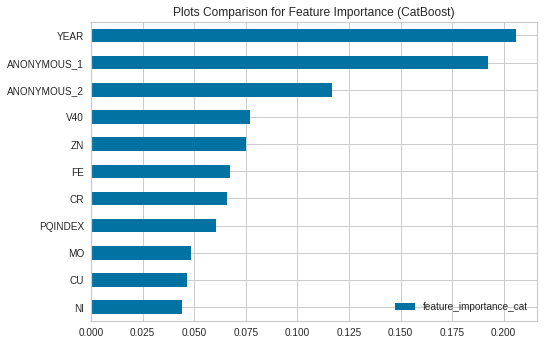

In [ ]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [ ]:
def objectiveET(trial, X, y):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_1'], y.loc[test_idx,'Score_1']

        #학습모델 생성
        model = ExtraTreesRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train7, y_train7), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-10 12:55:16,890] A new study created in memory with name: no-name-0366c6b9-3245-4dc0-899c-eb188f39f90a
[I 2022-12-10 12:55:22,127] Trial 0 finished with value: 0.37312206463853137 and parameters: {'max_depth': 5, 'max_leaf_nodes': 495, 'n_estimators': 429}. Best is trial 0 with value: 0.37312206463853137.
[I 2022-12-10 12:55:29,248] Trial 1 finished with value: 0.3601622910971089 and parameters: {'max_depth': 12, 'max_leaf_nodes': 608, 'n_estimators': 330}. Best is trial 1 with value: 0.3601622910971089.
[I 2022-12-10 12:55:30,392] Trial 2 finished with value: 0.362703044475985 and parameters: {'max_depth': 12, 'max_leaf_nodes': 150, 'n_estimators': 93}. Best is trial 1 with value: 0.3601622910971089.
[I 2022-12-10 12:55:34,723] Trial 3 finished with value: 0.3612994548404122 and parameters: {'max_depth': 10, 'max_leaf_nodes': 272, 'n_estimators': 335}. Best is trial 1 with value: 0.3601622910971089.
[I 2022-12-10 12:55:36,528] Trial 4 finished with value: 0.3842506331661575

study.best_params: 0.35977040198249643
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 893, 'n_estimators': 346}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 893, 'n_estimators': 346}


In [ ]:
param_et = studyET.best_params

clf_et1 = ExtraTreesRegressor(**param_et, random_state=42)

In [ ]:
clf_et1.fit(X_train7, y_train7.Score_1)

pred_test_et = clf_et1.predict(X_test)

y_test['pred_et'] = [labeling(pred, 0.4) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.3533
F1 Score : 0.2272
Macro F1 Score : 0.4718 

[[1477   80]
 [1090  172]]


In [ ]:
y_test['pred_et'] = [labeling(pred, 0.5) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_1),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.3533
F1 Score : 0.2664
Macro F1 Score : 0.5606 

[[2012  128]
 [ 555  124]]


In [ ]:
optuna.visualization.plot_param_importances(studyET)

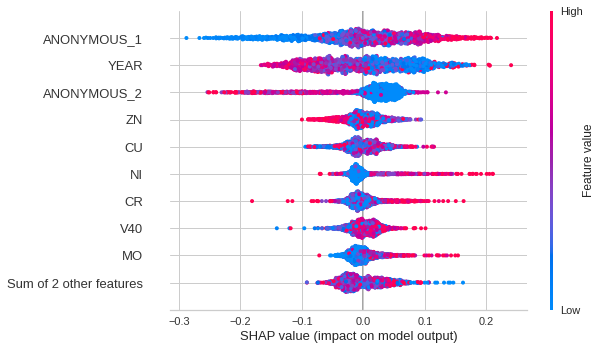

In [ ]:
explainer_et = shap.Explainer(clf_et1)
shap_values_et = explainer_et(X_train7)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [ ]:
fi_et = pd.DataFrame(clf_et1.feature_importances_, index=X_train7.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

,feature_importance_et
ANONYMOUS_1,0.168986
YEAR,0.135478
CU,0.098017
ZN,0.083602
FE,0.083233
V40,0.082101
ANONYMOUS_2,0.080712
PQINDEX,0.075958
CR,0.073329
MO,0.069290


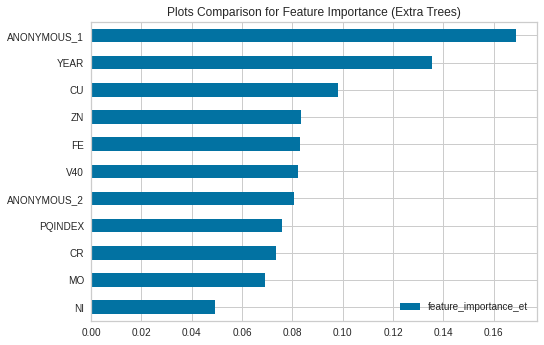

In [ ]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

### stacking

In [ ]:
# pred_test_stack = 0.15*pred_test_dt + 0.1*pred_test_svr + 0.15*pred_test_xgb + 0.15*pred_test_rf + 0.15*pred_test_lgbm + 0.15*pred_test_cat + 0.15*pred_test_et

# y_test['pred_mean'] = [labeling(pred, threshold=0.5) for pred in pred_test_stack]

# print('MAE :', round(mean_absolute_error(pred_test_stack, y_test.Score_1),4))
# print('F1 Score :', competition_metric(y_test.pred_mean, y_test.Y_LABEL)[0])
# print('Macro F1 Score :', competition_metric(y_test.pred_mean, y_test.Y_LABEL)[1], '\n')
# print(confusion_matrix(y_test.pred_mean, y_test.Y_LABEL))

MAE : 0.3294
F1 Score : 0.2564
Macro F1 Score : 0.5685 

[[2139  152]
 [ 428  100]]


In [ ]:
# pred_test_median = pd.DataFrame({'xgb' : pred_test_xgb, 
#                                  'rf' : pred_test_rf, 
#                                  'lgbm' : pred_test_lgbm, 
#                                  'cat' : pred_test_cat,
#                                  'et' : pred_test_et,
#                                  'dt' : pred_test_dt,
#                                  'svr' : pred_test_svr}).median(axis=1).values

# y_test['pred_median'] = [labeling(pred, threshold=0.5) for pred in pred_test_median]

# print('MAE :', round(mean_absolute_error(pred_test_median, y_test.Score_1),4))
# print('F1 Score :', competition_metric(y_test.pred_median, y_test.Y_LABEL)[0])
# print('Macro F1 Score :', competition_metric(y_test.pred_median, y_test.Y_LABEL)[1], '\n')
# print(confusion_matrix(y_test.pred_median, y_test.Y_LABEL))

MAE : 0.3417
F1 Score : 0.2509
Macro F1 Score : 0.5638 

[[2122  152]
 [ 445  100]]


In [ ]:
# # blending
# pred_test_real_xgb = clf_xgb.predict(real_test)
# pred_test_real_rf = clf_rf.predict(real_test)
# pred_test_real_lgbm = clf_lgbm.predict(real_test)
# pred_test_real_cat = clf_cat.predict(real_test)
# pred_test_real_et = clf_et1.predict(real_test)
# pred_test_real_dt = clf_dt.predict(real_test)
# pred_test_real_svr = clf_svr.predict(real_test)
# pred_test_real_stack = 0.15*pred_test_real_dt + 0.1*pred_test_real_svr + 0.15*pred_test_real_xgb + 0.15*pred_test_real_rf + 0.15*pred_test_real_lgbm + 0.15*pred_test_real_cat + 0.15*pred_test_real_et
# pred_test_real = 0.5*pred_test_real_stack + 0.1*pred_test_real_dt + 0.05*pred_test_real_svr + 0.05*pred_test_real_xgb + 0.05*pred_test_real_rf + 0.05*pred_test_real_lgbm + 0.1*pred_test_real_cat + 0.1*pred_test_real_et

In [ ]:
# real_pred = [labeling(pred, threshold=0.5) for pred in pred_test_real_stack]
# submit = pd.read_csv('sample_submission.csv')
# submit['Y_LABEL'] = real_pred
# submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,0
4,TEST_0004,1


In [ ]:
# submit.Y_LABEL.value_counts()

0    4875
1    1166
Name: Y_LABEL, dtype: int64

In [ ]:
# submit.to_csv('sub_one_stack_0.5.csv', index=False)